In [2]:
import mindspore
print("MindSpore version:", mindspore.__version__)


MindSpore version: 2.3.0


**Evaluamos los Datos** para revisar las cabeceras y que el set funcione adecuadamente

In [1]:
import scipy.io as sio

# Carga el archivo .mat
data = sio.loadmat("S10_E1_A1.mat")

# Mira qué variables hay adentro
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition', 'age', 'circumference', 'frequency', 'gender', 'height', 'weight', 'laterality', 'sensor'])


Ahora tratamos de tener un dataset segmentado, balanceado y dividido en train/test; para proceder a entrenar MindSpore

In [6]:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split


# 1. Cargar el archivo .mat
data = sio.loadmat("S10_E1_A1.mat")

emg = data['emg']           # (N_muestras x 16)
stimulus = data['stimulus'].flatten()  # (N_muestras,)

print("EMG shape:", emg.shape)
print("Stimulus shape:", stimulus.shape)

# 2. Definir parámetros de ventanas
fs = int(data['frequency'][0][0])  # frecuencia de muestreo, ej. 2000 Hz
window_size = int(0.2 * fs)        # 200 ms
step_size = int(0.05 * fs)         # 50 ms solapamiento

X = []
y = []

# 3. Crear ventanas deslizantes
for start in range(0, len(emg) - window_size, step_size):
    end = start + window_size
    segment = emg[start:end, :]
    label = int(stimulus[end])   # etiqueta al final de la ventana
    
    # ignorar ventanas de reposo (label = 0)
    if label != 0:
        X.append(segment)
        y.append(label)

X = np.array(X)   # (n_samples, window_size, 16)
y = np.array(y)   # (n_samples,)

print("X shape:", X.shape)
print("y shape:", y.shape)

# 4. Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


EMG shape: (149919, 16)
Stimulus shape: (149919,)
X shape: (9116, 40, 16)
y shape: (9116,)
Train: (7292, 40, 16) Test: (1824, 40, 16)


Con esta salida tenemos 14919 muestras crudas con 16 canales EMG, en donde la etiqueta de gesto de cada muuestra se marca al 0 como reposo y >0 a un gesto específico

Cada ejemplo es una ventana de 40 muestras con 16 canales

### **Definición de la arquitectura**

Ahora creamos una clase **EMGNetRobust,** que es un modelo **CNN+LSTM** para señales EMG

In [5]:
import mindspore as ms
import mindspore.nn as nn
from mindspore import Tensor

class EMGNetRobust(nn.Cell):
    def __init__(self, num_classes):
        super(EMGNetRobust, self).__init__()
        
        # 1. CNN para features locales
        self.conv_block = nn.SequentialCell([
            nn.Conv1d(in_channels=16, out_channels=64, kernel_size=5, stride=1, pad_mode='pad'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(64, 128, kernel_size=3, stride=1, pad_mode='pad'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        ])
        
        # 2. LSTM para dependencias temporales
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        
        # 3. Clasificador denso
        self.classifier = nn.SequentialCell([
            nn.Dense(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Dense(128, num_classes)
        ])

    def construct(self, x):
        # Entrada: (batch, time, channels) → CNN espera (batch, channels, time)
        x = x.transpose(0, 2, 1)  # (B, 16, 40)
        x = self.conv_block(x)    # (B, 128, T')

        # Volver a (B, T', features) para LSTM
        x = x.transpose(0, 2, 1)  # (B, T', 128)
        
        out, _ = self.lstm(x)     # (B, T', 64)
        out = out[:, -1, :]       # tomar el último estado temporal
        out = self.classifier(out)
        return out


Segmentamiento en ventanas cortas de 40 muestras

In [7]:
import scipy.io as sio
import numpy as np

# Cargar archivo .mat
data = sio.loadmat("S10_E1_A1.mat")
emg = data['emg']
stimulus = data['stimulus'].flatten()

# Ventanas de 40 samples
win_size = 40
X, y = [], []
for i in range(0, len(emg) - win_size, win_size):
    X.append(emg[i:i+win_size, :])       # (40, 16)
    y.append(stimulus[i+win_size-1])     # etiqueta del final de la ventana

X = np.array(X)
y = np.array(y)

print("X:", X.shape, "y:", y.shape)


X: (3747, 40, 16) y: (3747,)


Convertimos a dataset entrenable 

In [8]:
import mindspore.dataset as ds
import mindspore as ms

# Convertir a float32
X = X.astype(np.float32)
y = y.astype(np.int32)

# Dividir en train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset MindSpore
train_dataset = ds.NumpySlicesDataset({"data": X_train, "label": y_train}, shuffle=True)
train_dataset = train_dataset.batch(64)

test_dataset = ds.NumpySlicesDataset({"data": X_test, "label": y_test}, shuffle=False)
test_dataset = test_dataset.batch(64)


Usamos la red EMGNetRobust

In [11]:
class EMGNetRobust(nn.Cell):
    def __init__(self, num_classes):
        super(EMGNetRobust, self).__init__()
        
        # 1. CNN para features locales
        self.conv_block = nn.SequentialCell([
            nn.Conv1d(in_channels=16, out_channels=64, kernel_size=5, stride=1, pad_mode='pad'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(64, 128, kernel_size=3, stride=1, pad_mode='pad'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        ])
        
        # 2. LSTM para dependencias temporales
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        
        # 3. Clasificador denso
        self.classifier = nn.SequentialCell([
            nn.Dense(64, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),   # 👈 actualizado
            nn.Dense(128, num_classes)
        ])

    def construct(self, x):
        # Entrada: (batch, time, channels) → CNN espera (batch, channels, time)
        x = x.transpose(0, 2, 1)  # (B, 16, 40)
        x = self.conv_block(x)    # (B, 128, T')

        # Volver a (B, T', features) para LSTM
        x = x.transpose(0, 2, 1)  # (B, T', 128)
        
        out, _ = self.lstm(x)     # (B, T', 64)
        out = out[:, -1, :]       # tomar el último estado temporal
        out = self.classifier(out)
        return out



Evaluar y predecir

In [12]:
metrics = model.eval(test_dataset, dataset_sink_mode=False)
print("Resultados en test:", metrics)

# Predicción de intención
sample = X_test[0:1]   # un segmento
pred = model.predict(ms.Tensor(sample, ms.float32))
print("Predicción:", pred.asnumpy().argmax(axis=1))
print("Etiqueta real:", y_test[0])


Resultados en test: {'acc': 0.5626666666666666}
Predicción: [0]
Etiqueta real: 11


Entrenamiento con 40 y con 20 samples

In [15]:
import scipy.io as sio
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.dataset as ds
from mindspore.train import Model
from sklearn.model_selection import train_test_split

# ======================
# 1. Cargar dataset
# ======================
data = sio.loadmat("S10_E1_A1.mat")
emg = data['emg']
stimulus = data['stimulus'].flatten()

def make_dataset(emg, stimulus, win_size=40):
    X, y = [], []
    for i in range(0, len(emg) - win_size, win_size):
        X.append(emg[i:i+win_size, :])
        y.append(stimulus[i+win_size-1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

# Dataset normal (40 samples)
X40, y40 = make_dataset(emg, stimulus, win_size=40)
# Dataset anticipado (20 samples)
X20, y20 = make_dataset(emg, stimulus, win_size=20)

print("X40:", X40.shape, "y40:", y40.shape)
print("X20:", X20.shape, "y20:", y20.shape)

# ======================
# 2. Dividir train/test
# ======================
def split_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_ds = ds.NumpySlicesDataset({"data": X_train, "label": y_train}, shuffle=True).batch(64)
    test_ds  = ds.NumpySlicesDataset({"data": X_test, "label": y_test}, shuffle=False).batch(64)
    return train_ds, test_ds, X_test, y_test

train40, test40, X40_test, y40_test = split_dataset(X40, y40)
train20, test20, X20_test, y20_test = split_dataset(X20, y20)

# ======================
# 3. Entrenamiento
# ======================
def train_and_eval(train_ds, test_ds, num_classes, epochs=5):
    net = EMGNetRobust(num_classes=num_classes)
    loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    optimizer = nn.Adam(net.trainable_params(), learning_rate=0.001)
    model = Model(net, loss_fn=loss_fn, optimizer=optimizer, metrics={"acc"})
    
    # 👇 Aquí el fix
    print(f"\n=== Entrenando con ventanas de {train_ds.output_shapes()[0][1]} muestras ===")
    model.train(epochs, train_ds, dataset_sink_mode=False)
    metrics = model.eval(test_ds, dataset_sink_mode=False)
    print("Resultados:", metrics)
    return model


# Entrenar ambos modelos
model40 = train_and_eval(train40, test40, num_classes=len(np.unique(y40)), epochs=5)
model20 = train_and_eval(train20, test20, num_classes=len(np.unique(y20)), epochs=5)

# ======================
# 4. Predicción de ejemplo
# ======================
sample = ms.Tensor(X20_test[0:1], ms.float32)
pred = model20.predict(sample)
print("Predicción (20 samples):", pred.asnumpy().argmax(axis=1), "Etiqueta real:", y20_test[0])


X40: (3747, 40, 16) y40: (3747,)
X20: (7495, 20, 16) y20: (7495,)

=== Entrenando con ventanas de 40 muestras ===
Resultados: {'acc': 0.5293333333333333}

=== Entrenando con ventanas de 20 muestras ===
Resultados: {'acc': 0.5330220146764509}
Predicción (20 samples): [11] Etiqueta real: 11


Gráfico de loss para 40 y 20


=== Entrenando con ventanas de 40 muestras ===

=== Entrenando con ventanas de 20 muestras ===


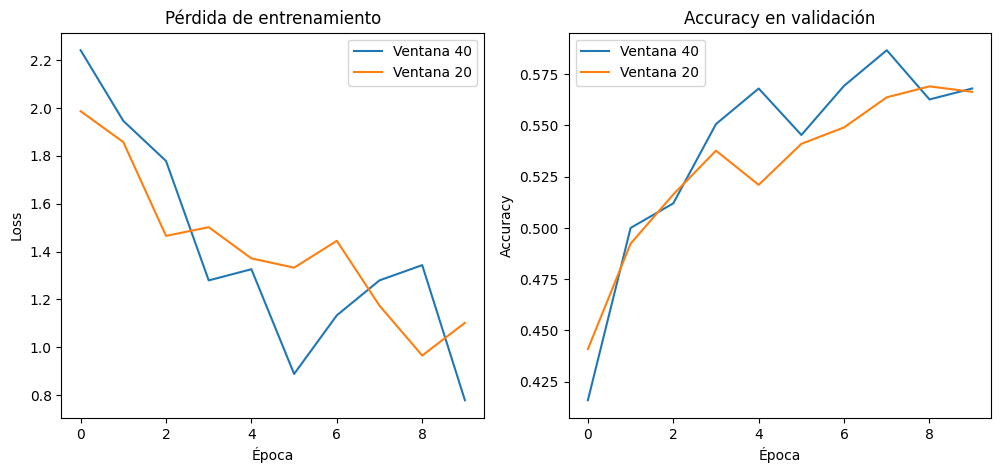

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mindspore import nn, Model, Tensor
from mindspore.dataset import GeneratorDataset
from mindspore.train.callback import Callback
from sklearn.model_selection import train_test_split

# ======================
# Callback para registrar métricas
# ======================
class LossAccHistory(Callback):
    def __init__(self, model, test_ds):
        self.model = model
        self.test_ds = test_ds
        self.losses = []
        self.val_acc = []

    def on_train_epoch_end(self, run_context):
        cb_params = run_context.original_args()

        # Guardar loss de la época
        try:
            self.losses.append(cb_params.net_outputs.asnumpy().mean())
        except:
            self.losses.append(float(cb_params.net_outputs[0].asnumpy().mean()))

        # Evaluar accuracy en validación
        metrics = self.model.eval(self.test_ds, dataset_sink_mode=False)
        self.val_acc.append(metrics["acc"])


# ======================
# Funciones auxiliares
# ======================
def make_datasets(X, y, test_size=0.2, batch_size=64):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    train_ds = GeneratorDataset(list(zip(X_train, y_train)), column_names=["data", "label"])
    test_ds = GeneratorDataset(list(zip(X_test, y_test)), column_names=["data", "label"])
    train_ds = train_ds.batch(batch_size)
    test_ds = test_ds.batch(batch_size)
    return train_ds, test_ds

def train_and_eval_with_logs(X, y, num_classes, epochs=5):
    train_ds, test_ds = make_datasets(X, y)
    
    net = EMGNetRobust(num_classes=num_classes)
    loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    optimizer = nn.Adam(net.trainable_params(), learning_rate=0.001)
    model = Model(net, loss_fn=loss_fn, optimizer=optimizer, metrics={"acc"})
    
    history = LossAccHistory(model, test_ds)  # pasar modelo y test_ds
    
    print(f"\n=== Entrenando con ventanas de {train_ds.output_shapes()[0][1]} muestras ===")
    model.train(epochs, train_ds, callbacks=[history], dataset_sink_mode=False)
    
    return model, history


# ======================
# Entrenar modelos (40 y 20)
# ======================
model40, hist40 = train_and_eval_with_logs(X40, y40, num_classes=len(np.unique(y40)), epochs=10)
model20, hist20 = train_and_eval_with_logs(X20, y20, num_classes=len(np.unique(y20)), epochs=10)

# ======================
# Graficar resultados
# ======================
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(hist40.losses, label="Ventana 40")
plt.plot(hist20.losses, label="Ventana 20")
plt.title("Pérdida de entrenamiento")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(hist40.val_acc, label="Ventana 40")
plt.plot(hist20.val_acc, label="Ventana 20")
plt.title("Accuracy en validación")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


Matriz de Confusión

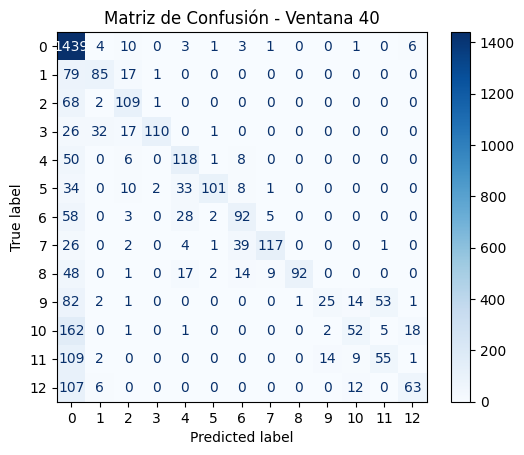

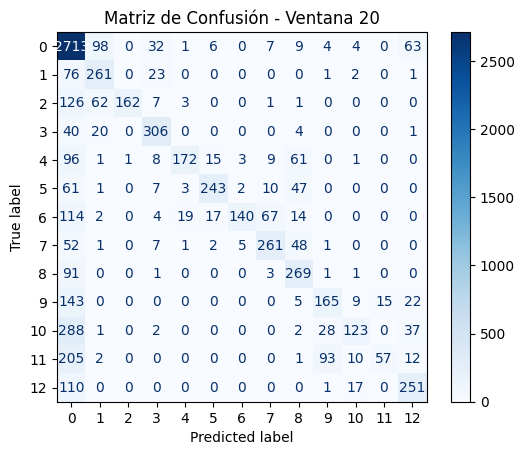

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X, y, title):
    # Pasar a Tensor y obtener predicciones
    preds = []
    for i in range(len(X)):
        x_tensor = Tensor(np.expand_dims(X[i], 0), ms.float32)
        y_pred = model.predict(x_tensor).asnumpy().argmax(axis=1)
        preds.append(y_pred[0])
    
    cm = confusion_matrix(y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

# Matriz para ventana 40
plot_confusion_matrix(model40, X40, y40, "Matriz de Confusión - Ventana 40")
# Matriz para ventana 20
plot_confusion_matrix(model20, X20, y20, "Matriz de Confusión - Ventana 20")


Curva ROC-AUC por Clase

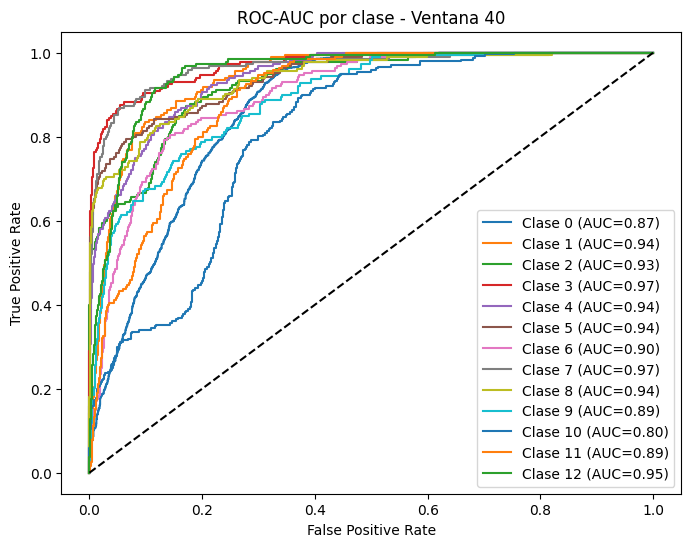

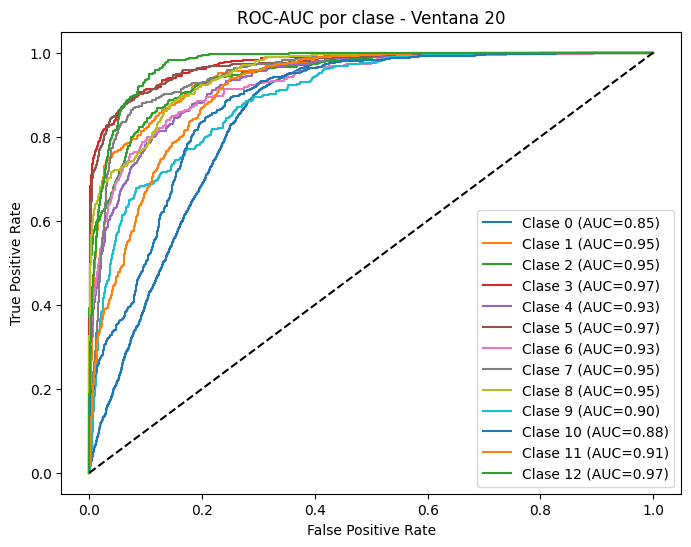

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_auc(model, X, y, title):
    num_classes = len(np.unique(y))
    
    # Binarizar etiquetas para ROC multiclase
    y_bin = label_binarize(y, classes=range(num_classes))
    
    # Obtener probabilidades
    probs = []
    for i in range(len(X)):
        x_tensor = Tensor(np.expand_dims(X[i], 0), ms.float32)
        y_prob = model.predict(x_tensor).asnumpy()
        probs.append(y_prob[0])
    probs = np.array(probs)
    
    # Graficar curva ROC por clase
    plt.figure(figsize=(8,6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Clase {i} (AUC={roc_auc:.2f})")
    
    plt.plot([0,1],[0,1],'k--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# ROC-AUC para ventana 40
plot_roc_auc(model40, X40, y40, "ROC-AUC por clase - Ventana 40")
# ROC-AUC para ventana 20
plot_roc_auc(model20, X20, y20, "ROC-AUC por clase - Ventana 20")
